<a href="https://colab.research.google.com/github/JHKim-snu/AI_Expert/blob/main/Logic_Gate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logic Gate Example


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Separator(nn.Module):
  def __init__(self,func=None):
    super(Separator, self).__init__()
    self.a = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    self.b = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    self.c = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    if func is not None:
      self.func = func
    else:
      self.func = torch.sigmoid
  
  def forward(self, x):
    val_ = self.func(self.a * x[:,0] + self.b * x[:,1] - self.c).unsqueeze(-1)
    return val_

In [5]:
class DataGenerator(Dataset):
  def __init__(self, type_, length, std=0.08):
    self.length = length
    if type_ == 'and':
      self.val_l = [0, 0, 0, 1]
    elif type_ == 'or':
      self.val_l = [0, 1, 1, 1]
    elif type_ == 'xor':
      self.val_l = [0, 1, 1, 0]
    else:
      self.val_l = [0, 0, 0, 0]
     
    self.dataset = []
    for i in range(length):
      x = np.random.normal(i%2, std)      #0,1,0,1,0,1,0,1,...
      y = np.random.normal((i//2)%2, std) #0,0,1,1,0,0,1,1,...
      val = self.val_l[i%4]
      self.dataset.append((x, y, val))
      
  def get_dataset(self):
    return self.dataset
    
  def __len__(self):
    return self.length
    
  def __getitem__(self, idx):
    x, y, val = self.dataset[idx]
    return (torch.Tensor([x, y]), torch.Tensor([val]))

In [6]:

DATASET = DataGenerator('and', 1000)
lr = 0.01 # learning rate
batch_size = 20
num_epochs = 30
num_workers = 4
graph_x = np.linspace(-1.0, 2, 2)

params = {
    'batch_size' : batch_size,
    'shuffle' : True,
    'num_workers' : num_workers
}

dataloader = DataLoader(DATASET, **params)
model = Separator().cuda()
optimizer = Adam(model.parameters(), lr=lr)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


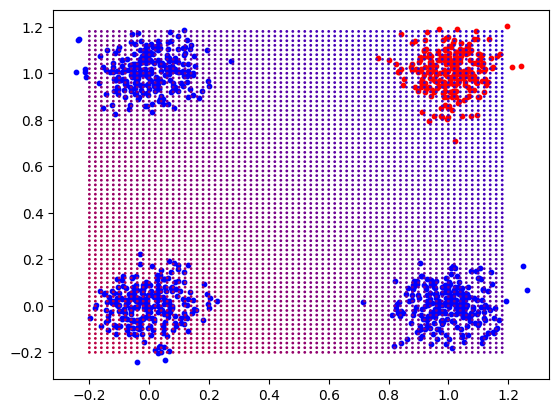

Loss : 0.33068
Loss : 0.27878
Loss : 0.23339
Loss : 0.19350
Loss : 0.16270


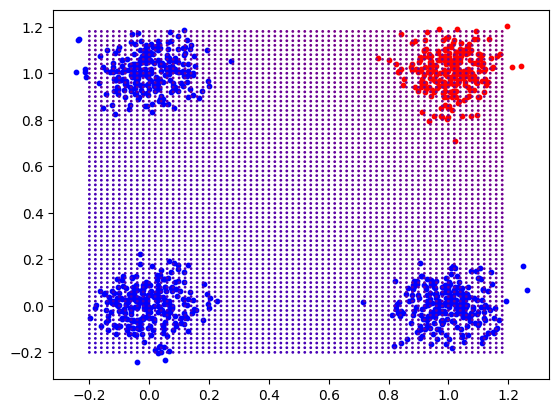

Loss : 0.13931
Loss : 0.12161
Loss : 0.10787
Loss : 0.09685
Loss : 0.08778


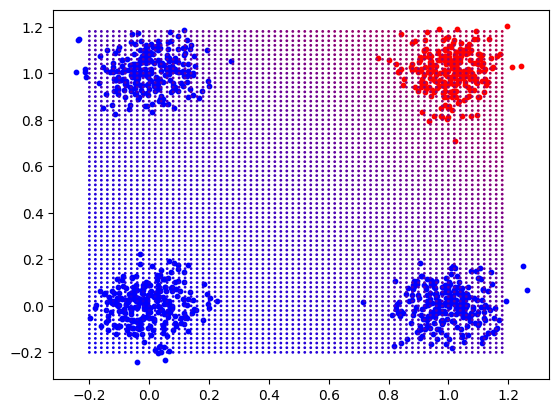

Loss : 0.08003
Loss : 0.07340
Loss : 0.06770
Loss : 0.06268
Loss : 0.05806


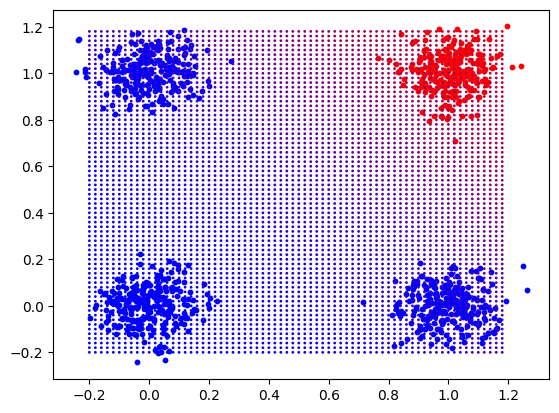

Loss : 0.05408
Loss : 0.05043
Loss : 0.04719
Loss : 0.04421
Loss : 0.04148


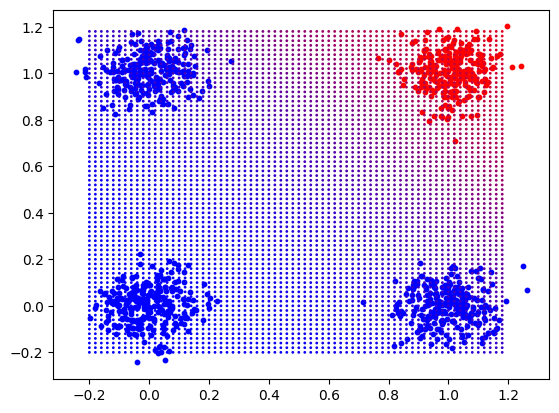

Loss : 0.03905
Loss : 0.03675
Loss : 0.03473
Loss : 0.03279
Loss : 0.03100


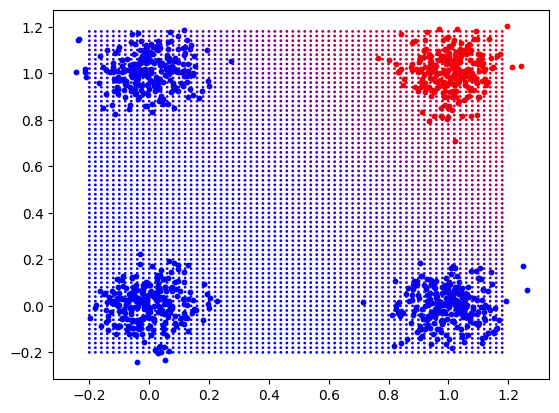

Loss : 0.02936
Loss : 0.02785
Loss : 0.02647
Loss : 0.02520
Loss : 0.02399


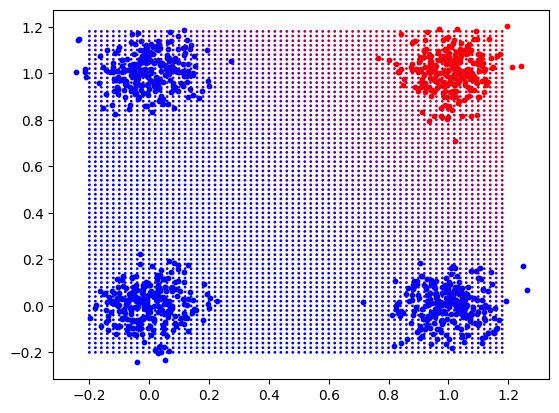

In [7]:
def show(model):
  for item in DATASET.get_dataset():
    x, y, val = item
    if val == 1:
      plt.scatter(x, y, c='red', s=10)
    else:
      plt.scatter(x, y, c='blue', s=10)
  t = torch.arange(70,dtype=torch.float32)*0.02-0.2
  x = t.unsqueeze(0).repeat(70,1).unsqueeze(-1)
  y = t.unsqueeze(1).repeat(1,70).unsqueeze(-1)
  data = torch.cat((x,y),-1).view(-1,2)
  with torch.no_grad():
    val = (model(data.cuda())).cpu()
  colors = torch.cat((val,torch.zeros_like(val),1-val),-1).numpy()
  plt.scatter(data.numpy()[:,0],data.numpy()[:,1], c=colors, s=1)
  plt.show()

show(model)


for epoch in range(num_epochs):
  total_loss = 0
  for x, val in dataloader:
    x = x.cuda()
    val = val.cuda()
    optimizer.zero_grad()
    val_ =  model(x)
    loss = torch.sum(torch.pow(val - val_, 2))
    
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print("Loss : {:.5f}".format(total_loss / len(DATASET)))
  
  if epoch % 5  == 4:
    model.eval()
    show(model)
    model.train()